**TODO:**
- [x] Build NTEE-10 major groups.
- [x] Vectorize output labels.
- [x] Vectorize input texts.
- [x] Spell check.
- [ ] Add more records of 'VI' (International, Foreign Affairs - Q).


In [3]:
# Check GPU device.
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())
# Specify GPU to use. 
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"; 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1";  

['/job:localhost/replica:0/task:0/device:GPU:0']


In [4]:
#https://richliao.github.io/supervised/classification/2016/11/26/textclassifier-convolutional/
#https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
#RNN

import os
import pandas as pd
import re
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
from spellchecker import SpellChecker
import string

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding

# For encoding labels.
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [5]:
# Code as 10 major groups.
major_group_dict={'I': ['A'],
                  'II': ['B'],
                  'III': ['C', 'D'],
                  'IV': ['E', 'F', 'G', 'H'],
                  'V': ['I', 'J', 'K', 'L', 'M', 'N', 'O', 'P'],
                  'VI': ['Q'],
                  'VII': ['R', 'S', 'T', 'U', 'V', 'W'],
                  'VIII': ['X'],
                  'IX': ['Y'],
                  'X': ['Z'],
                 }
def ntee2major(string):
    global major_group_dict
    return [s for s in major_group_dict.keys() if string in major_group_dict[s]][0]

In [6]:
file_list=os.listdir('../../dataset/df_train.pkl.gz/')
df_train=pd.DataFrame()
for file in file_list:
    df_train=pd.concat([df_train, 
                        pd.read_pickle('../../dataset/df_train.pkl.gz/'+file, compression='gzip')])
df_train['mission_prgrm']=df_train['mission']+'; '+df_train['prgrm_dsc']
df_train['NTEE_M']=df_train['NTEE1'].apply(ntee2major)

len(df_train['mission_prgrm']), len(df_train['NTEE1'].drop_duplicates()), len(df_train['NTEE_M'].drop_duplicates())

(229472, 25, 9)

In [7]:
# Build training data frame.
small_num=0
while small_num<1000: # Make sure each category has at least 500 records.
    trainDF = df_train[df_train.mission.notna() & df_train.NTEE1.notna()].sample(120000)
    small_num=trainDF.groupby('NTEE_M').count().sort_values('EIN').iloc[0]['EIN']

# Build validation data frame.
small_num=0
while small_num<1000: # Make sure each category has at least 500 records.
    valDF = df_train[df_train.mission.notna() & df_train.NTEE1.notna()].sample(120000)
    small_num=valDF.groupby('NTEE_M').count().sort_values('EIN').iloc[0]['EIN']

In [8]:
# See the composition by NTEE major groups.
print(trainDF.groupby('NTEE_M').count()['EIN']/len(trainDF), '\n'*2, valDF.groupby('NTEE_M').count()['EIN']/len(valDF))

NTEE_M
I       0.111467
II      0.167017
III     0.051650
IV      0.116175
IX      0.038117
V       0.299917
VI      0.013392
VII     0.173567
VIII    0.028700
Name: EIN, dtype: float64 

 NTEE_M
I       0.111725
II      0.167750
III     0.050842
IV      0.115883
IX      0.038592
V       0.300100
VI      0.012992
VII     0.173175
VIII    0.028942
Name: EIN, dtype: float64


### Prepare labels.

In [9]:
def one_hot(label_list, class_list):
    int_encoder=LabelEncoder().fit(class_list) # Build the encoder.
    label_int_encoded=int_encoder.transform(label_list) # One-dimensional integer encoded.
    return np_utils.to_categorical(label_int_encoded) # Multi-dimensional binary/one-hot encoded.

y_train=one_hot(label_list=trainDF['NTEE_M'], class_list=list(major_group_dict.keys()))
y_val=one_hot(label_list=valDF['NTEE_M'], class_list=list(major_group_dict.keys()))

### Prepare input text.

In [10]:
stop_list=stopwords.words('english')+list(string.punctuation)
def tokenize_stopwords_remove(string):
    global stop_list
    return [s for s in nltk.word_tokenize(string) if s not in stop_list]

In [ ]:
text_token_list_train=trainDF['mission_prgrm'].apply(tokenize_stopwords_remove)
text_token_list_val=valDF['mission_prgrm'].apply(tokenize_stopwords_remove)

**Moved to preprocessing pipeline.**
```Python
# Spell check function. Return corrected word if unknown; return original word if known.
def spellcheck(word_string_list):
    return [SpellChecker().correction(word=s).upper() for s in word_string_list]

# Parallel computing
p = Pool(48)
text_token_list_train=p.map(spellcheck, text_token_list_train)
text_token_list_val=p.map(spellcheck, text_token_list_val)
# Pool.map keep the original order of data passed to map.
# https://stackoverflow.com/questions/41273960/python-3-does-pool-keep-the-original-order-of-data-passed-to-map
```

In [ ]:
# Build word index for train and validation texts.
tokenizer=Tokenizer()
tokenizer.fit_on_texts(text_token_list_train.to_list()+text_token_list_val.to_list())
print(list(tokenizer.word_index.items())[0:5])

[('and', 1), ('the', 2), ('to', 3), ('of', 4), ('in', 5)]


In [ ]:
seq_encoding_text_train=tokenizer.texts_to_sequences(text_token_list_train)
seq_encoding_text_val=tokenizer.texts_to_sequences(text_token_list_val)

In [ ]:
# Pads sequences to the same length.
x_train=pad_sequences(sequences=seq_encoding_text_train,
                      maxlen=max([len(s) for s in seq_encoding_text_train]), # Max length of the sequence.
                      dtype = "int32", padding = "post", truncating = "post", 
                      value = 0 # Zero is used for representing None or Unknown.
                     )
x_val=pad_sequences(sequences=seq_encoding_text_val,
                    maxlen=max([len(s) for s in seq_encoding_text_train]), # Max length of the sequence.
                    dtype = "int32", padding = "post", truncating = "post", 
                    value = 0 # Zero is used for representing None or Unknown.
                     )

In [ ]:
# https://medium.com/@Petuum/embeddings-a-matrix-of-meaning-4de877c9aa27
# Note that in the embedding matrix above, each row corresponds to a word and each column corresponds to a dimension (axis). 
# Typically, we store this in a dense fashion, where we have a list of words and row ID’s which map to the corresponding row of the matrix. 
# For the above example, we’d have the following list in addition to the matrix:
# { hello: 0, there: 1, texas: 2, world: 3, … }

## Classifier.

### Not using pre-trained embedding.

In [149]:
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
embedding_layer = Embedding(input_dim=len(tokenizer.word_index), # Size of vocabulary.
                            input_length=max([len(s) for s in seq_encoding_text_train]), # Length of input, i.e., length of padded sequence.
                            output_dim=32, # Size of the vector space in which words will be embedded.
                           )

In [ ]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, BatchNormalization, GlobalMaxPooling1D, GRU, Dropout, LSTM
from keras.models import Model

sequence_input = Input(shape=(max([len(s) for s in seq_encoding_text_train]),), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Flatten()(embedded_sequences)
x = Dense(units=512, activation='relu')(x)
x = Dense(units=128, activation='tanh')(x)
preds = Dense(units=len(y_train[0]), activation='softmax')(x) #softmax

model = Model(sequence_input, preds)

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam', #'rmsprop',
              metrics=['acc',precision, recall])

history = model.fit(x_train, y_train, validation_split=0.8,
#                     validation_data=(x_val, y_val),
                    epochs=2, batch_size=50)

In [150]:
# Add metrics.
# https://stackoverflow.com/questions/43076609/how-to-calculate-precision-and-recall-in-keras
import tensorflow as tf
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

precision = as_keras_metric(tf.metrics.precision)
recall = as_keras_metric(tf.metrics.recall)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten

# define the model
model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(units=512, activation='sigmoid'))
model.add(Dense(units=256, activation='sigmoid'))
model.add(Dense(units=len(y_train[0]), activation='relu'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', precision, recall])
# summarize the model
print(model.summary())

In [ ]:
# fit the model
# Batch size: https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
history=model.fit(x_train, y_train, validation_split=0.3, epochs=25, verbose=1)

In [ ]:
# evaluate the model
loss, accuracy = model.evaluate(x_val, y_val, verbose=1)
print('Accuracy: %f' % (accuracy*100))

### Use pre-trained GloVe embedding.

In [ ]:
import gensim.downloader as api
EMBEDDING_DIM=100
glove_word_vector=api.load('glove-wiki-gigaword-'+str(EMBEDDING_DIM))

In [ ]:
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, EMBEDDING_DIM))

In [ ]:
for word, index in tqdm(tokenizer.word_index.items()):
    try:
        embedding_matrix[index] = glove_word_vector.get_vector(word)
    except:
        pass
        # words not found in embedding index will be all-zeros.

100%|██████████| 253313/253313 [00:00<00:00, 370562.67it/s]


In [ ]:
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
embedding_layer = Embedding(input_dim=len(tokenizer.word_index)+1, # Size of vocabulary.
                            input_length=max([len(s) for s in seq_encoding_text_train]), # Length of input, i.e., length of padded sequence.
                            output_dim=EMBEDDING_DIM, # Size of the vector space in which words will be embedded.
                            weights=[embedding_matrix],
                            trainable=False
                           )

In [ ]:
# Add metrics.
# https://stackoverflow.com/questions/43076609/how-to-calculate-precision-and-recall-in-keras
import tensorflow as tf
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

precision = as_keras_metric(tf.metrics.precision)
recall = as_keras_metric(tf.metrics.recall)
f1 = as_keras_metric(tf.contrib.metrics.f1_score)

In [ ]:
# config = tf.ConfigProto()
# config.gpu_options.allow_growth=True
# sess = tf.Session(config=config)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalMaxPool1D, Conv1D
from keras.layers.advanced_activations import LeakyReLU, PReLU

# define the model
model = Sequential()
model.add(embedding_layer)
# model.add(Flatten())
model.add(Conv1D(128, 5, activation='softplus'))
model.add(GlobalMaxPool1D())
model.add(Dense(units=32, activation='sigmoid'))
model.add(Dense(units=16, activation='softplus'))
# model.add(PReLU()) # https://medium.com/tinymind/a-practical-guide-to-relu-b83ca804f1f7
model.add(Dense(units=16, activation='tanh'))
model.add(Dense(units=16, activation='softplus'))
model.add(Dense(units=len(y_train[0]), activation='softmax'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 
#                                                                      precision, recall
                                                                    ])
# summarize the model
print(model.summary())

# fit the model
history=model.fit(x_train, y_train, validation_split=0.3, epochs=100, verbose=1)

'''
(10, sigmoid; 9, relu): loss: 0.4414 - acc: 0.8896 - precision: 0.1604 - recall: 0.8439 - val_loss: 0.3964 - val_acc: 0.8943 - val_precision: 0.1632 - val_recall: 0.8974
(10, softmax; 9, relu): loss: 0.5685 - acc: 0.8888 - precision: 0.1371 - recall: 0.8051 - val_loss: 0.5532 - val_acc: 0.8895 - val_precision: 0.1394 - val_recall: 0.8151
(10, relu;    9, relu): loss: 0.5377 - acc: 0.8838 - precision: 0.1646 - recall: 0.8411 - val_loss: 0.4271 - val_acc: 0.8903 - val_precision: 0.1558 - val_recall: 0.8884
(10, relu; 9, softmax): loss: 0.2596 - acc: 0.9037 - precision: 0.1110 - recall: 0.9992 - val_loss: 0.2303 - val_acc: 0.9135 - val_precision: 0.1111 - val_recall: 1.0000
(10, relu; 9, sigmoid): loss: 0.2681 - acc: 0.8975 - precision: 0.1110 - recall: 0.9992 - val_loss: 0.2272 - val_acc: 0.9121 - val_precision: 0.1111 - val_recall: 1.0000
(10, tanh; 9, sigmoid): loss: 0.2959 - acc: 0.8940 - precision: 0.1110 - recall: 0.9992 - val_loss: 0.2572 - val_acc: 0.9066 - val_precision: 0.1111 - val_recall: 1.0000
(10, relu;    9, tanh): loss: 0.4241 - acc: 0.8599 - precision: 0.1110 - recall: 0.9992 - val_loss: 0.3609 - val_acc: 0.8885 - val_precision: 0.1111 - val_recall: 1.0000

(32, relu; 16, tanh; 9, sigmoid): loss: 0.2590 - acc: 0.9034 - precision: 0.1110 - recall: 0.9992 - val_loss: 0.2186 - val_acc: 0.9180 - val_precision: 0.1111 - val_recall: 1.0000
(32, relu; 16, tanh; 9,    relu): loss: 0.5613 - acc: 0.8654 - precision: 0.1360 - recall: 0.7180 - val_loss: 0.3850 - val_acc: 0.8889 - val_precision: 0.1394 - val_recall: 0.8721
(32, relu; 16, relu; 9,    relu): loss: 0.3902 - acc: 0.8876 - precision: 0.1396 - recall: 0.9328 - val_loss: 0.3618 - val_acc: 0.8889 - val_precision: 0.1377 - val_recall: 0.9532
(32, softmax; 16, relu; 9, relu): loss: 0.6418 - acc: 0.8916 - precision: 0.1212 - recall: 0.7585 - val_loss: 0.6097 - val_acc: 0.8942 - val_precision: 0.1276 - val_recall: 0.7584
(32, sigmoid; 16, relu; 9, relu): loss: 0.5048 - acc: 0.8885 - precision: 0.1421 - recall: 0.7762 - val_loss: 0.3169 - val_acc: 0.8889 - val_precision: 0.1363 - val_recall: 0.8788

(32, sigmoid; 32, sigmoid; 16, relu; 16, relu; 9, relu): loss: 0.3325 - acc: 0.8879 - precision: 0.1251 - recall: 0.9766 - val_loss: 0.4644 - val_acc: 0.7910 - val_precision: 0.1257 - val_recall: 0.9785
(32, softmax; 32, softmax; 16, relu; 16, relu; 9, relu): loss: 1.1298 - acc: 0.8889 - precision: 0.0933 - recall: 0.4219 - val_loss: 1.1113 - val_acc: 0.8889 - val_precision: 0.0952 - val_recall: 0.4569

1. Don't use sigmoid/softmax/tanh for output layer.
2. Using relu near output layer increases loss but improve precision.
3. sigmoid/tanh/softmax decreases loss, but also decreases precision.
4. Possible strategy: use softmax near input layer, use relu near output layer.
'''

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 28647, 100)        25331400  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28643, 128)        64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
__________

## Check results.

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.


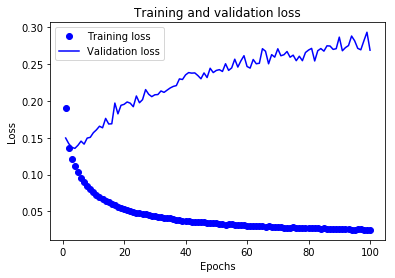

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

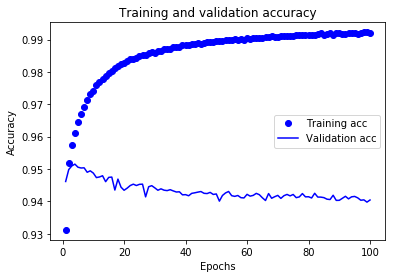

In [24]:
plt.clf()   # clear figure
history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [25]:
'''https://machinelearningmastery.com/how-to-make-classification-and-regression-predictions-for-deep-learning-models-in-keras/
In the case of a two-class (binary) classification problem, the sigmoid activation function is often used in the output layer. 
The predicted probability is taken as the likelihood of the observation belonging to class 1, or inverted (1 – probability) to give the probability for class 0.
In the case of a multi-class classification problem, the softmax activation function 
is often used on the output layer and the likelihood of the observation for each class is returned as a vector.
'''

y_prob = model.predict(x_val, verbose=1)
y_classes = y_prob.argmax(axis=-1)
y_classes_prob=[s.max() for s in y_prob]
y_classes_val=y_val.argmax(axis=-1)

df_val=pd.DataFrame({'pred':y_classes, 
                     'true':y_classes_val, 
                     'prob':y_classes_prob})
len(df_val[df_val.pred==df_val.true])/len(df_val)

120000/120000 [==============================] - 118s 980us/step


0.8065

In [27]:
df_95=df_val[df_val.prob>.95]
print(len(df_95[df_95.pred==df_95.true])/len(df_95), len(df_95)/len(df_val))

0.8855383130305224 0.794225


In [36]:
df_val.sample(10)

,pred,true,prob
2715,7,2,0.545607
12731,3,7,0.994292
77231,5,5,0.998583
39466,2,2,0.993600
40808,7,7,0.997733
55521,0,5,0.993345
98084,5,5,0.998267
32629,3,1,0.227505
97716,5,5,0.998162
48723,8,8,0.512429


In [37]:
df_val.groupby('pred')[['prob']].describe()

prob                                                              \
        count      mean       std       min       25%       50%       75%   
pred                                                                        
0     14574.0  0.947898  0.140834  0.181094  0.994786  0.997717  0.998336   
1     20047.0  0.938727  0.150843  0.199948  0.982048  0.996910  0.998982   
2      6813.0  0.937554  0.145990  0.230144  0.983532  0.995575  0.997143   
3     13946.0  0.919894  0.163432  0.202485  0.950082  0.994085  0.997833   
4      4788.0  0.915918  0.158874  0.223830  0.934571  0.991566  0.997457   
5     34993.0  0.951979  0.125865  0.173467  0.987138  0.997629  0.998319   
6      2456.0  0.769482  0.228869  0.182271  0.593661  0.862013  0.967078   
7     18602.0  0.923707  0.159183  0.198981  0.957083  0.996431  0.998265   
8      3781.0  0.864114  0.213472  0.189253  0.806864  0.985537  0.997941   

                
           max  
pred            
0     0.999913  
1     0.999559  
2     0.999125  
3     0.999361  
4     0.999467  
5     0.999602  
6     0.996433  
7     0.999453  
8     0.999207

In [28]:
df_val.groupby('pred')[['prob']].describe()

prob                                                              \
        count      mean       std       min       25%       50%       75%   
pred                                                                        
0      6472.0  0.926960  0.161377  0.201276  0.967786  0.998207  0.999427   
1     10120.0  0.932083  0.141317  0.187849  0.963087  0.996856  0.998673   
2      2929.0  0.907906  0.163671  0.259162  0.904953  0.994907  0.998996   
3      7110.0  0.916791  0.161245  0.262828  0.938327  0.996855  0.998905   
4      1986.0  0.903018  0.161161  0.235908  0.882732  0.990259  0.997365   
5     16172.0  0.931750  0.135043  0.200071  0.948975  0.995243  0.998743   
6       843.0  0.696661  0.217745  0.242645  0.509826  0.695344  0.918251   
7     12870.0  0.919407  0.153473  0.261656  0.931813  0.997049  0.999624   
8      1498.0  0.850485  0.203469  0.266933  0.727755  0.976792  0.996452   

                
           max  
pred            
0     0.999708  
1     0.999277  
2     0.999484  
3     0.999202  
4     0.999328  
5     0.999214  
6     0.999637  
7     0.999863  
8     0.998747

## Draft.

In [208]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, BatchNormalization, GlobalMaxPooling1D, GRU, Dropout, LSTM
from keras.models import Model

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
'''
x = GRU(units=128, activation='tanh', return_sequences=True)(embedded_sequences)

x = LSTM(units=256, activation='tanh', return_sequences=False)(embedded_sequences)
x = Dropout(0.2)(x)

#x = LSTM(units=128, activation='tanh', return_sequences=True)(x)
#x = Dropout(0.2)(x)
'''
# x = Dropout(0.2)(x)
x = Flatten()(embedded_sequences)
x = Dense(units=512, activation='relu')(x)
x = Dense(units=128, activation='tanh')(x)
preds = Dense(units=9, activation='softmax')(x) #softmax

# x = Dense(units=512, activation='relu')(x)
# x = Dense(units=128, activation='relu')(x)
# preds = Dense(units=25, activation='sigmoid')(x) #softmax

model = Model(sequence_input, preds)

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam', #'rmsprop',
              metrics=['acc',precision, recall])

history = model.fit(x_train, y_train, validation_split=0.8,
#                     validation_data=(x_val, y_val),
                    epochs=2, batch_size=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 1000, 200)         6692600   
_________________________________________________________________
flatten_13 (Flatten)         (None, 200000)            0         
_________________________________________________________________
dense_38 (Dense)             (None, 512)               102400512 
_________________________________________________________________
dense_39 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_40 (Dense)             (None, 9)                 1161      
Total params: 109,159,937
Trainable params: 102,467,337
Non-trainable params: 6,692,600
______________________________________________________

In [79]:
score = model.evaluate(x_val, y_val, batch_size=500, verbose=1)
score

60000/60000 [==============================] - 25s 412us/step


[0.19112927243113517, 0.9295742606123288, 0.1111111119389534, 1.0]

In [34]:
len(df_val[df_val.pred==df_val.true])

37694

In [38]:
df_95.pred.unique()

array([1, 0, 7, 5, 3, 4, 2])